<a href="https://colab.research.google.com/github/mitsuhazuki/deep-image-prior/blob/master/projet_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Partie 1


In [ ]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/mitsuhazuki/deep-image-prior
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 414 (delta 47), reused 110 (delta 40), pack-reused 289
Receiving objects: 100% (414/414), 378.32 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (202/202), done.
Updating files: 100% (61/61), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libs

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
import pickle
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [ ]:
## denoising
# image must be 24 bit color
fname = 'data/denoising/F16_GT.png'

## Load image

In [ ]:
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)

### add noise

In [ ]:
# Add synthetic noise
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

In [ ]:
# Pour sauvegarder une nouvelle image bruité dans le drive
pickle.dump( img_noisy_np, open( "/content/drive/MyDrive/Deep_Image_Prior/denoising/img_noisy_np.p", "wb" ))

## load img_noisy_np from drive

In [ ]:
# Charger l'image bruité du drive
img_noisy_np = pickle.load( open( "/content/drive/MyDrive/Deep_Image_Prior/denoising/img_noisy_np.p", "rb" ))

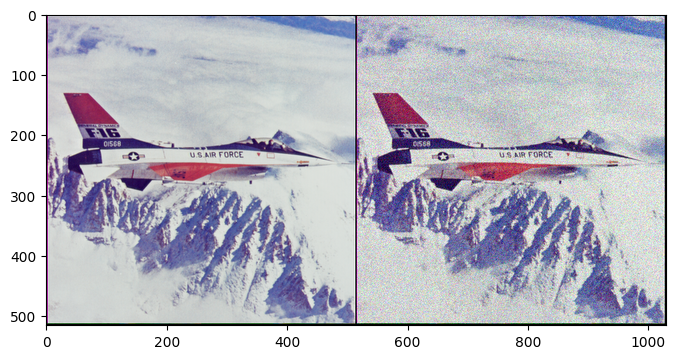

In [ ]:
if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 6)

## Setup

In [ ]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99


num_iter = 3000
input_depth = 32
figsize = 4

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

## Optimize

In [ ]:
list_out_np = []

In [ ]:
list_out_np = pickle.load( open( "/content/drive/MyDrive/Deep_Image_Prior/denoising/list_out_np.p", "rb" ))

In [ ]:
index = 0
while index < 10:

    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

        
    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()


    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    out_avg = None
    last_net = None
    psrn_noisy_last = 0

    i = 0
    def closure():
        
        global i, out_avg, psrn_noisy_last, last_net, net_input
        
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        out = net(net_input)
        
        # Smoothing
        if out_avg is None:
            out_avg = out.detach()
        else:
            out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
                
        total_loss = mse(out, img_noisy_torch)
        total_loss.backward()
            
        
        psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0])
        psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0])
        psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])
        
        # Note that we do not have GT for the "snail" example
        # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
        print ('\rN%d Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (index, i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), end='')
        if  PLOT and i % show_every == 0:
            out_np = torch_to_np(out)
            plot_image_grid([np.clip(out_np, 0, 1), 
                            np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
            
            
        
        # Backtracking
        if i % show_every:
            if psrn_noisy - psrn_noisy_last < -5: 
                print('Falling back to previous checkpoint.')

                for new_param, net_param in zip(last_net, net.parameters()):
                    net_param.data.copy_(new_param.cuda())

                return total_loss*0
            else:
                last_net = [x.detach().cpu() for x in net.parameters()]
                psrn_noisy_last = psrn_noisy
                
        i += 1

        return total_loss

    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)

    list_out_np.append(torch_to_np(net(net_input)))

    pickle.dump( list_out_np, open( "/content/drive/MyDrive/Deep_Image_Prior/denoising/list_out_np.p", "wb" ))

    index += 1

In [ ]:
list_out_np = pickle.load( open( "/content/drive/MyDrive/Deep_Image_Prior/denoising/list_out_np.p", "rb" ))

In [ ]:
k=0
for out_np in list_out_np:
  print('denoising', k)
  q = plot_image_grid([np.clip(out_np, 0, 1), img_noisy_np], factor=13);
  k += 1

denoising 0


AssertionError: ignored

## Conversion numpy -> mat

In [ ]:
from scipy.io import savemat
savemat('/content/drive/MyDrive/Deep_Image_Prior/denoising/outputs.mat', {'outputs': list_out_np})

# Partie 2

## 1 - Variance

## New Section